In [1]:
# ==========================================
# 0) Imports + paths (project-consistent)
# ==========================================
import json
from pathlib import Path
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Notebook location → project root assumption:
#   notebook/
#     └── ../data/runs/YYYY-MM-DD/accounting/
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

RUN_DATE = date.today().isoformat()
DATA_DIR = PROJECT_ROOT / "data" / "runs" / RUN_DATE / "accounting"

print("Using DATA_DIR:", DATA_DIR.resolve())

SYM_CSV   = DATA_DIR / "pnl_by_symbol.csv"
PAIR_CSV  = DATA_DIR / "pnl_by_pair.csv"
UNDER_CSV = DATA_DIR / "pnl_by_underlying.csv"
TOTALS_JS = DATA_DIR / "totals.json"

for p in [SYM_CSV, PAIR_CSV, UNDER_CSV, TOTALS_JS]:
    if not p.exists():
        raise FileNotFoundError(f"Missing required file: {p}")

df_sym   = pd.read_csv(SYM_CSV)
df_pair  = pd.read_csv(PAIR_CSV)
df_under = pd.read_csv(UNDER_CSV)
totals   = json.loads(TOTALS_JS.read_text())

print("Loaded shapes:",
      "symbols", df_sym.shape,
      "pairs", df_pair.shape,
      "underlyings", df_under.shape)


Using DATA_DIR: C:\Users\werdn\Documents\Investing\ls-algo\data\runs\2026-02-02\accounting
Loaded shapes: symbols (213, 13) pairs (213, 10) underlyings (73, 10)


In [37]:
# ==========================================
# 1) Helper: pick component columns safely
# ==========================================
COMPONENTS = [
    "realized_pnl",
    "unrealized_pnl",
    "dividends",              # net dividends (in your rebuilt)
    "borrow_fees",
    "short_credit_interest",
    "other_fees",
]

# Some versions keep these too (optional)
OPTIONAL = ["dividends_gross", "pil_dividends", "withholding_tax"]

for c in COMPONENTS + OPTIONAL:
    if c not in df_sym.columns:
        df_sym[c] = 0.0

if "total_pnl" not in df_sym.columns:
    df_sym["total_pnl"] = df_sym[COMPONENTS].sum(axis=1)

df_sym["trading_pnl"] = df_sym["realized_pnl"] + df_sym["unrealized_pnl"]
df_sym["carry_pnl"] = df_sym["dividends"] + df_sym["borrow_fees"] + df_sym["short_credit_interest"] + df_sym["other_fees"]

df_sym.head()


,symbol,underlying,pair,description,realized_pnl,unrealized_pnl,dividends,withholding_tax,pil_dividends,borrow_fees,short_credit_interest,other_fees,total_pnl,dividends_gross,trading_pnl,carry_pnl,bucket,leg_type
0,META,META,META (spot),META PLATFORMS INC-CLASS A,5.659428e+02,972.546143,0.0,0.0,0.0,0.000000,0.000000,0.0,1538.488976,0.0,1538.488976,0.000000,Other / Spot,Spot
1,BLSX,BLSH,BLSH | BLSX,TRADR 2X LONG BLSH DAILY ETF,0.000000e+00,996.125109,0.0,0.0,0.0,-1.519550,0.266562,0.0,994.872121,0.0,996.125109,-1.252988,Leveraged ETF,2X
2,APPX,APP,APP | APPX,TRADR 2X LONG APP DAILY ETF,0.000000e+00,980.368693,0.0,0.0,0.0,-1.688824,0.296256,0.0,978.976126,0.0,980.368693,-1.392567,Leveraged ETF,2X
3,UNHG,UNH,UNH | UNHG,LEVERAGE SHARES 2X UNH,0.000000e+00,972.232001,0.0,0.0,0.0,-1.340830,0.235211,0.0,971.126382,0.0,972.232001,-1.105619,Leveraged ETF,2X
4,NVDA,NVDA,NVDA (spot),NVIDIA CORP,3.300000e-07,919.879363,0.0,0.0,0.0,0.000000,0.000000,0.0,919.879363,0.0,919.879363,0.000000,Other / Spot,Spot


In [38]:
ETF_CAGR_PATH = PROJECT_ROOT / "config" / "etf_cagr.csv"
# ==========================================
# 1) Build mapping tables from etf_cagr.csv
#   - ETF -> underlying
#   - ETF -> LevType (2x / CC)
# ==========================================
etf = pd.read_csv(ETF_CAGR_PATH)
cols = {c.lower(): c for c in etf.columns}

# identify columns flexibly
etf_col = next(cols[c] for c in ["etf","symbol","ticker","etf_symbol"] if c in cols)
under_col = next(cols[c] for c in ["underlying","underlyingsymbol","underlying_symbol","root"] if c in cols)
lev_col = cols["levtype"]

etf_map = etf[[etf_col, under_col, lev_col]].copy()
etf_map.columns = ["etf", "underlying", "LevType"]
etf_map["etf"] = etf_map["etf"].astype(str).str.upper().str.strip()
etf_map["underlying"] = etf_map["underlying"].astype(str).str.upper().str.strip()
etf_map["LevType"] = etf_map["LevType"].astype(str).str.upper().str.strip()

ETF_TO_UNDER = dict(zip(etf_map["etf"], etf_map["underlying"]))
ETF_TO_LEVTYPE = dict(zip(etf_map["etf"], etf_map["LevType"]))

etf_map.head()


,etf,underlying,LevType
0,AAPU,AAPL,2X
1,AMUU,AMD,2X
2,AMZU,AMZN,2X
3,AVL,AVGO,2X
4,BITX,IBIT,2X


In [41]:
# ==========================================
# 1) Keep ETF legs only (exclude spot entirely)
# ==========================================
df_etf = df_sym[df_sym["symbol"].isin(ETF_TO_LEVTYPE.keys())].copy()

print("Rows before:", len(df_sym))
print("Rows after ETF-only filter:", len(df_etf))
print(df_etf["symbol"].nunique(), "ETF symbols kept")

# ==========================================
# 2) Attach LevType and enforce underlying mapping
# ==========================================
df_etf["LevType"] = df_etf["symbol"].map(ETF_TO_LEVTYPE)

assert df_etf["LevType"].notna().all(), "Found ETF without LevType"

df_etf["bucket"] = df_etf["LevType"].map({
    "2X": "Leveraged ETF",
    "CC": "Covered Call"
})

df_etf[["symbol","underlying","LevType","bucket"]].head()



Rows before: 213
Rows after ETF-only filter: 141
141 ETF symbols kept


,symbol,underlying,LevType,bucket
1,BLSX,BLSH,2X,Leveraged ETF
2,APPX,APP,2X,Leveraged ETF
3,UNHG,UNH,2X,Leveraged ETF
5,OPEG,OPEN,2X,Leveraged ETF
6,PLTA,PLTR,2X,Leveraged ETF


In [53]:
from pathlib import Path
from datetime import date
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

RUN_DATE = date.today().isoformat()

RUN_DIR = PROJECT_ROOT / "data" / "runs" / RUN_DATE
FLEX_DIR = RUN_DIR / "ibkr_flex"
ACC_DIR  = RUN_DIR / "accounting"

FLEX_POS = FLEX_DIR / "flex_positions.xml"
SYM_CSV  = ACC_DIR / "pnl_by_symbol.csv"
PAIR_CSV = ACC_DIR / "pnl_by_pair.csv"
TOTALS_JS = ACC_DIR / "totals.json"

ETF_CAGR_PATH = PROJECT_ROOT / "config" / "etf_cagr.csv"

for p in [FLEX_POS, SYM_CSV, PAIR_CSV, TOTALS_JS, ETF_CAGR_PATH]:
    if not p.exists():
        raise FileNotFoundError(f"Missing: {p}")

print("RUN_DATE:", RUN_DATE)
print("FLEX_POS:", FLEX_POS)
print("ACC_DIR:", ACC_DIR)


RUN_DATE: 2026-02-02
FLEX_POS: c:\Users\werdn\Documents\Investing\ls-algo\data\runs\2026-02-02\ibkr_flex\flex_positions.xml
ACC_DIR: c:\Users\werdn\Documents\Investing\ls-algo\data\runs\2026-02-02\accounting


In [55]:
df_sym = pd.read_csv(SYM_CSV)
df_pair = pd.read_csv(PAIR_CSV)

etf = pd.read_csv(ETF_CAGR_PATH)
cols = {c.lower(): c for c in etf.columns}

etf_col  = next(cols[c] for c in ["etf","symbol","ticker","etf_symbol"] if c in cols)
under_col = next(cols[c] for c in ["underlying","underlyingsymbol","underlying_symbol","root"] if c in cols)
lev_col  = cols["levtype"]

etf_map = etf[[etf_col, under_col, lev_col]].copy()
etf_map.columns = ["symbol", "underlying_cfg", "LevType"]
etf_map["symbol"] = etf_map["symbol"].astype(str).str.upper().str.strip()
etf_map["underlying_cfg"] = etf_map["underlying_cfg"].astype(str).str.upper().str.strip()
etf_map["LevType"] = etf_map["LevType"].astype(str).str.upper().str.strip()

ETF_TO_LEVTYPE = dict(zip(etf_map["symbol"], etf_map["LevType"]))
ETF_TO_UNDER   = dict(zip(etf_map["symbol"], etf_map["underlying_cfg"]))

# Keep ETF legs only (aligned with your backtest universe)
df_etf = df_sym[df_sym["symbol"].astype(str).str.upper().isin(ETF_TO_LEVTYPE.keys())].copy()
df_etf["symbol"] = df_etf["symbol"].astype(str).str.upper().str.strip()

# force underlying from config to avoid IBKR weirdness
df_etf["underlying"] = df_etf["symbol"].map(ETF_TO_UNDER)

df_etf["LevType"] = df_etf["symbol"].map(ETF_TO_LEVTYPE)
df_etf["bucket"] = df_etf["LevType"].map({"2X": "Leveraged ETF", "CC": "Covered Call"})

df_etf["beta_proxy"] = df_etf["LevType"].map({"2X": 2.0, "CC": 1.0}).fillna(1.0)

df_etf[["symbol","underlying","LevType","bucket","beta_proxy"]].head()


,symbol,underlying,LevType,bucket,beta_proxy
1,BLSX,BLSH,2X,Leveraged ETF,2.0
2,APPX,APP,2X,Leveraged ETF,2.0
3,UNHG,UNH,2X,Leveraged ETF,2.0
5,OPEG,OPEN,2X,Leveraged ETF,2.0
6,PLTA,PLTR,2X,Leveraged ETF,2.0


In [67]:
def canonical_symbol(sym: str) -> str:
    if sym is None:
        return ""
    s = str(sym).strip().upper()
    m = re.match(r"^([A-Z]{1,5})[ \-\.]([A-Z])$", s)  # BRK B / BRK-B / BRK.B -> BRK.B
    if m:
        return f"{m.group(1)}.{m.group(2)}"
    return s

def to_base(amount, fx):
    try:
        return float(amount) * float(fx)
    except Exception:
        return float(amount)

def parse_open_positions_xml(path: Path) -> pd.DataFrame:
    root = ET.parse(path).getroot()
    op = root.find(".//OpenPositions")
    if op is None:
        raise ValueError("Could not find <OpenPositions> in flex_positions.xml")

    rows = []
    for node in op:
        a = node.attrib
        sym = canonical_symbol(a.get("symbol","") or "")
        und = canonical_symbol(a.get("underlyingSymbol","") or "")
        position = float(a.get("position","0") or 0)
        pos_val  = float(a.get("positionValue","0") or 0)
        fx = float(a.get("fxRateToBase","1") or 1)

        rows.append({
            "symbol": sym,
            "underlyingSymbol": und,
            "position": position,
            "positionValue": pos_val,
            "fxRateToBase": fx,
            "positionValue_base": to_base(pos_val, fx),  # signed notional in base ccy
        })

    df = pd.DataFrame(rows)
    df = df[df["symbol"].astype(bool)].copy()
    return df

pos = parse_open_positions_xml(FLEX_POS)
pos.head()


,symbol,underlyingSymbol,position,positionValue,fxRateToBase,positionValue_base
0,AAPL,AAPL,51.0,13233.48,1.0,13233.48
1,AI,AI,375.0,4128.75,1.0,4128.75
2,ALAB,ALAB,36.0,5422.32,1.0,5422.32
3,AMD,AMD,95.0,22489.35,1.0,22489.35
4,AMZN,AMZN,82.0,19622.60,1.0,19622.60


In [68]:
cols = {c.lower(): c for c in etf.columns}

etf_col  = next(cols[c] for c in ["etf","symbol","ticker","etf_symbol"] if c in cols)
under_col = next(cols[c] for c in ["underlying","underlyingsymbol","underlying_symbol","root"] if c in cols)
lev_col  = cols["levtype"]

etf_map = etf[[etf_col, under_col, lev_col]].copy()
etf_map.columns = ["symbol", "underlying_cfg", "LevType"]
etf_map["symbol"] = etf_map["symbol"].astype(str).str.upper().map(canonical_symbol)
etf_map["underlying_cfg"] = etf_map["underlying_cfg"].astype(str).str.upper().map(canonical_symbol)
etf_map["LevType"] = etf_map["LevType"].astype(str).str.upper().str.strip()

ETF_TO_UNDER = dict(zip(etf_map["symbol"], etf_map["underlying_cfg"]))
ETF_TO_LEV   = dict(zip(etf_map["symbol"], etf_map["LevType"]))

set(ETF_TO_LEV.values())


{'2X', 'CC'}

In [69]:
COMPONENTS = [
    "realized_pnl","unrealized_pnl","dividends","borrow_fees","short_credit_interest","other_fees"
]
OPTIONAL = ["dividends_gross","pil_dividends","withholding_tax"]

for c in COMPONENTS + OPTIONAL:
    if c not in df_sym.columns:
        df_sym[c] = 0.0

if "total_pnl" not in df_sym.columns:
    df_sym["total_pnl"] = df_sym[COMPONENTS].sum(axis=1)

df_sym["trading_pnl"] = df_sym["realized_pnl"] + df_sym["unrealized_pnl"]
df_sym["carry_pnl"] = df_sym["dividends"] + df_sym["borrow_fees"] + df_sym["short_credit_interest"] + df_sym["other_fees"]


In [70]:
COMPONENTS = [
    "realized_pnl","unrealized_pnl","dividends","borrow_fees","short_credit_interest","other_fees"
]
OPTIONAL = ["dividends_gross","pil_dividends","withholding_tax"]

for c in COMPONENTS + OPTIONAL:
    if c not in df_sym.columns:
        df_sym[c] = 0.0

if "total_pnl" not in df_sym.columns:
    df_sym["total_pnl"] = df_sym[COMPONENTS].sum(axis=1)

df_sym["trading_pnl"] = df_sym["realized_pnl"] + df_sym["unrealized_pnl"]
df_sym["carry_pnl"] = df_sym["dividends"] + df_sym["borrow_fees"] + df_sym["short_credit_interest"] + df_sym["other_fees"]


In [71]:
# ETF legs only
df_etf = df_sym[df_sym["symbol"].astype(str).str.upper().map(canonical_symbol).isin(ETF_TO_LEV.keys())].copy()
df_etf["symbol"] = df_etf["symbol"].astype(str).str.upper().map(canonical_symbol)

# force underlying + LevType from config
df_etf["underlying"] = df_etf["symbol"].map(ETF_TO_UNDER)
df_etf["LevType"] = df_etf["symbol"].map(ETF_TO_LEV)
df_etf["bucket"] = df_etf["LevType"].map({"2X":"Leveraged ETF", "CC":"Covered Call"})

# beta proxy (used only for allocation weights)
df_etf["beta_proxy"] = df_etf["LevType"].map({"2X": 2.0, "CC": 1.0}).fillna(1.0)

# merge in actual notional from Flex OpenPositions
pos2 = pos[["symbol","position","positionValue_base"]].copy()
df_etf = df_etf.merge(pos2, on="symbol", how="left")

print("ETF legs:", len(df_etf), "Missing notional:", df_etf["positionValue_base"].isna().sum())
df_etf = df_etf.dropna(subset=["positionValue_base"]).copy()

df_etf[["symbol","underlying","LevType","positionValue_base","total_pnl"]].head()


ETF legs: 141 Missing notional: 40


,symbol,underlying,LevType,positionValue_base,total_pnl
0,BLSX,BLSH,2X,-2107.00,994.872121
1,APPX,APP,2X,-2542.22,978.976126
3,OPEG,OPEN,2X,-1927.02,808.126304
5,ETHT,ETHA,2X,-2626.26,797.135225
6,PTIR,PLTR,2X,-2509.80,794.341902


In [73]:
# Spot underlying PnL rows (symbol == underlying)
df_spot = df_sym.copy()
df_spot["symbol"] = df_spot["symbol"].astype(str).str.upper().map(canonical_symbol)
df_spot["underlying"] = df_spot["underlying"].astype(str).str.upper().map(canonical_symbol)

spot_rows = df_spot[df_spot["symbol"] == df_spot["underlying"]].copy()

# Spot PnL by underlying (this is the hedge PnL we will distribute)
spot_pnl_by_under = spot_rows.groupby("underlying", as_index=False)["total_pnl"].sum()
spot_pnl_by_under = spot_pnl_by_under.rename(columns={"total_pnl":"spot_hedge_pnl"})

# Allocation weights for each ETF leg in an underlying:
# weight = beta_proxy * abs(ETF notional)
df_etf["alloc_weight"] = df_etf["beta_proxy"] * df_etf["positionValue_base"].abs()

w_sum = df_etf.groupby("underlying", as_index=False)["alloc_weight"].sum().rename(columns={"alloc_weight":"alloc_weight_sum"})
df_etf = df_etf.merge(w_sum, on="underlying", how="left").merge(spot_pnl_by_under, on="underlying", how="left")
df_etf["spot_hedge_pnl"] = df_etf["spot_hedge_pnl"].fillna(0.0)

# Allocate spot hedge PnL across ETF legs
df_etf["spot_pnl_alloc"] = np.where(
    df_etf["alloc_weight_sum"] > 0,
    df_etf["spot_hedge_pnl"] * (df_etf["alloc_weight"] / df_etf["alloc_weight_sum"]),
    0.0
)

# Hedged ("excess") PnL per ETF leg
df_etf["pair_pnl_hedged"] = df_etf["total_pnl"] + df_etf["spot_pnl_alloc"]

df_etf[["underlying","symbol","bucket","total_pnl","spot_pnl_alloc","pair_pnl_hedged"]].head(10)


,underlying,symbol,bucket,total_pnl,spot_pnl_alloc,pair_pnl_hedged
0,BLSH,BLSX,Leveraged ETF,994.872121,-1058.251428,-63.379307
1,APP,APPX,Leveraged ETF,978.976126,-832.405828,146.570298
2,OPEN,OPEG,Leveraged ETF,808.126304,-830.659905,-22.533601
3,ETHA,ETHT,Leveraged ETF,797.135225,-755.109592,42.025633
4,PLTR,PTIR,Leveraged ETF,794.341902,-956.538760,-162.196859
5,SOEZ,SOLT,Leveraged ETF,789.749535,-792.702863,-2.953328
6,PLTR,PLTW,Covered Call,764.296816,-785.411392,-21.114576
7,ETHA,ETHU,Leveraged ETF,699.470629,-755.305107,-55.834478
8,ETHA,ETU,Leveraged ETF,688.531867,-759.594947,-71.063080
9,GXRP,XXRP,Leveraged ETF,664.598253,-691.134628,-26.536375


In [74]:
# ETF-only PnL by underlying/bucket
etf_under = (
    df_etf.groupby(["underlying","bucket"], as_index=False)["total_pnl"].sum()
    .pivot(index="underlying", columns="bucket", values="total_pnl")
    .fillna(0.0)
)

# Add spot hedge pnl and hedged total
spot_series = spot_pnl_by_under.set_index("underlying")["spot_hedge_pnl"]
etf_under["spot_hedge_pnl"] = spot_series.reindex(etf_under.index).fillna(0.0)

etf_under["ETF_TOTAL"] = etf_under[[c for c in ["Leveraged ETF","Covered Call"] if c in etf_under.columns]].sum(axis=1)
etf_under["HEDGED_TOTAL"] = etf_under["ETF_TOTAL"] + etf_under["spot_hedge_pnl"]

# If hedge is perfect, HEDGED_TOTAL should resemble "excess"/strategy return
etf_under = etf_under.sort_values("HEDGED_TOTAL")

display(etf_under.head(25))


bucket,Covered Call,Leveraged ETF,spot_hedge_pnl,ETF_TOTAL,HEDGED_TOTAL
underlying,,,,,
DKNG,201.984750,0.000000,-1035.773323,201.984750,-833.788573
IBIT,0.000000,1276.833599,-2061.391762,1276.833599,-784.558163
PLTR,764.296816,1170.392939,-2692.040337,1934.689756,-757.350581
MSFT,294.493564,932.193836,-1667.690476,1226.687400,-441.003076
SNOW,0.000000,489.895597,-890.970999,489.895597,-401.075402
MARA,299.516246,292.909957,-993.344136,592.426202,-400.917934
AMD,298.544793,-46.857100,-581.094795,251.687693,-329.407102
AI,566.867132,0.000000,-690.310149,566.867132,-123.443017
BA,0.000000,510.377955,-618.726571,510.377955,-108.348616


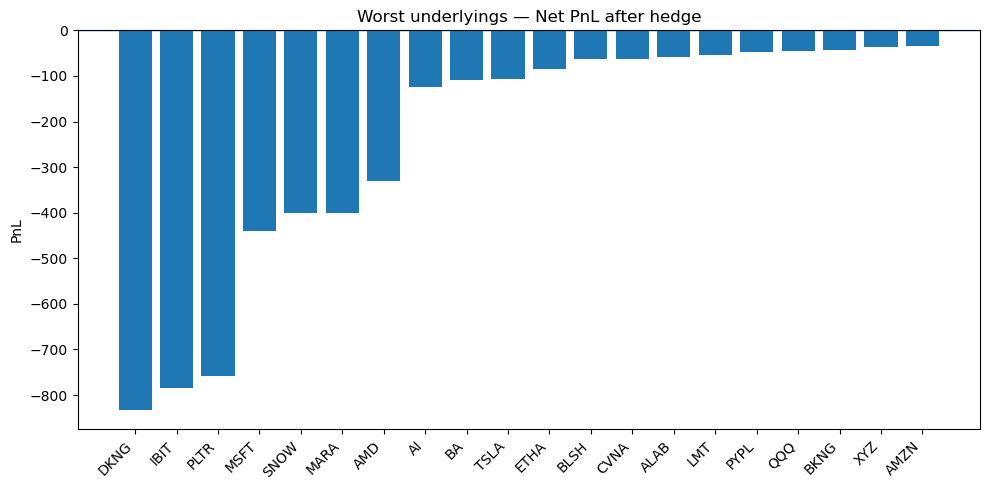

In [78]:
TOPN = 20
u = etf_under.head(TOPN).copy()

# Net after hedge
u["HEDGED_TOTAL"] = (
    u.get("Leveraged ETF", 0.0)
    + u.get("Covered Call", 0.0)
    + u["spot_hedge_pnl"]
)

plt.figure(figsize=(10,5))
plt.bar(u.index, u["HEDGED_TOTAL"])
plt.axhline(0, linewidth=1)
plt.xticks(rotation=45, ha="right")
plt.title("Worst underlyings — Net PnL after hedge")
plt.ylabel("PnL")
plt.tight_layout()
plt.show()


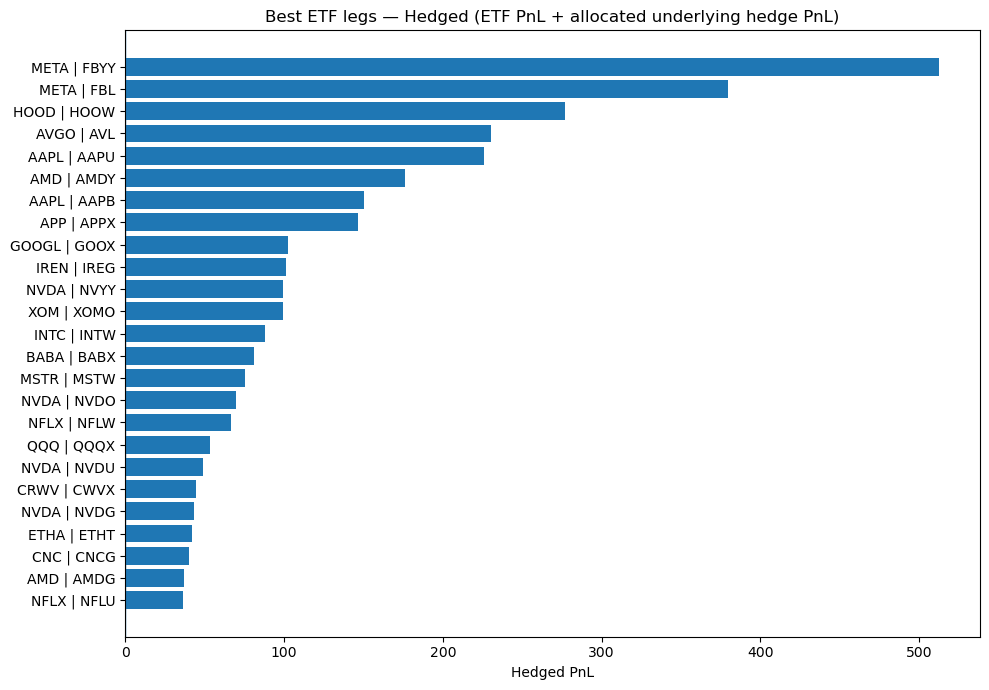

,underlying,symbol,bucket,positionValue_base,total_pnl,spot_pnl_alloc,pair_pnl_hedged
38,NFLX,NFLU,Leveraged ETF,-3228.34,261.654226,-225.182601,36.471625
45,AMD,AMDG,Leveraged ETF,-2791.04,189.324879,-152.394962,36.929916
26,CNC,CNCG,Leveraged ETF,-2898.68,367.966190,-327.624514,40.341676
3,ETHA,ETHT,Leveraged ETF,-2626.26,797.135225,-755.109592,42.025633
87,NVDA,NVDG,Leveraged ETF,-3449.16,-126.699019,169.968579,43.269559
95,CRWV,CWVX,Leveraged ETF,-3078.96,-272.202888,316.651515,44.448627
86,NVDA,NVDU,Leveraged ETF,-3417.96,-119.740996,168.431097,48.690102
57,QQQ,QQQX,Covered Call,-4824.60,44.033753,9.518565,53.552318
39,NFLX,NFLW,Covered Call,-4829.99,234.814134,-168.450304,66.363830
80,NVDA,NVDO,Leveraged ETF,-2705.33,-63.717112,133.313936,69.596824


In [79]:
best = df_etf.sort_values("pair_pnl_hedged").tail(25)

plt.figure(figsize=(10,7))
plt.barh(best["underlying"] + " | " + best["symbol"], best["pair_pnl_hedged"])
plt.axvline(0, linewidth=1)
plt.title("Best ETF legs — Hedged (ETF PnL + allocated underlying hedge PnL)")
plt.xlabel("Hedged PnL")
plt.tight_layout()
plt.show()

display(best[["underlying","symbol","bucket","positionValue_base","total_pnl","spot_pnl_alloc","pair_pnl_hedged"]])


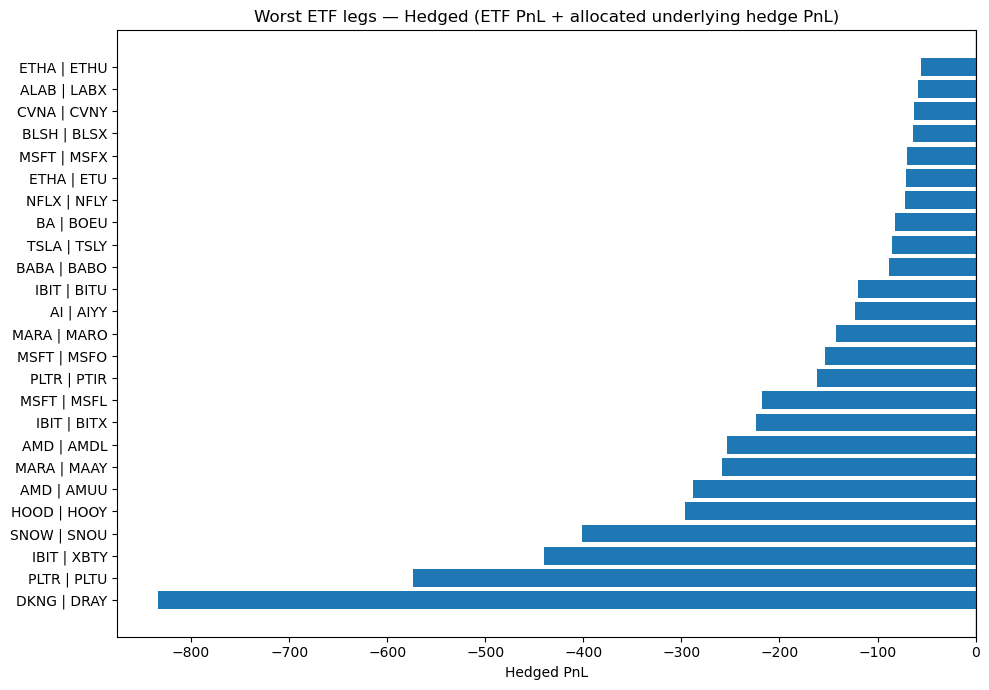

,underlying,symbol,bucket,positionValue_base,total_pnl,spot_pnl_alloc,pair_pnl_hedged
42,DKNG,DRAY,Covered Call,-4272.78,201.984750,-1035.773323,-833.788573
25,PLTR,PLTU,Leveraged ETF,-2492.88,376.051038,-950.090184,-574.039147
37,IBIT,XBTY,Leveraged ETF,-2951.71,268.099035,-708.479056,-440.380021
18,SNOW,SNOU,Leveraged ETF,-2702.15,489.895597,-890.970999,-401.075402
24,HOOD,HOOY,Covered Call,-4509.93,378.103243,-674.202409,-296.099166
89,AMD,AMUU,Leveraged ETF,-2795.43,-135.908818,-152.634663,-288.543481
33,MARA,MAAY,Leveraged ETF,-2908.46,292.909957,-551.270068,-258.360112
84,AMD,AMDL,Leveraged ETF,-2812.00,-100.273161,-153.539410,-253.812571
21,IBIT,BITX,Leveraged ETF,-2823.78,453.689759,-677.772880,-224.083122
22,MSFT,MSFL,Leveraged ETF,-3450.56,449.261318,-667.106350,-217.845032


In [76]:
worst = df_etf.sort_values("pair_pnl_hedged").head(25)

plt.figure(figsize=(10,7))
plt.barh(worst["underlying"] + " | " + worst["symbol"], worst["pair_pnl_hedged"])
plt.axvline(0, linewidth=1)
plt.title("Worst ETF legs — Hedged (ETF PnL + allocated underlying hedge PnL)")
plt.xlabel("Hedged PnL")
plt.tight_layout()
plt.show()

display(worst[["underlying","symbol","bucket","positionValue_base","total_pnl","spot_pnl_alloc","pair_pnl_hedged"]])
